In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

/Users/dc/anaconda/envs/3conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/dc/anaconda/envs/3conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


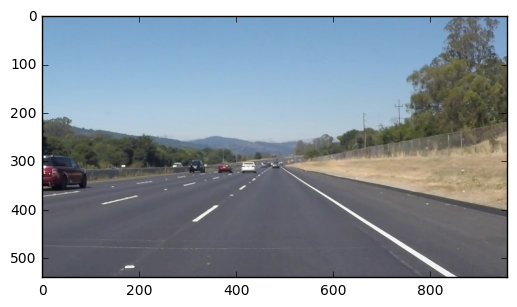

In [125]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [126]:
#helper function
def slope(x1,x2,y1,y2):
    return (y2-y1)/(x2-x1)

def dist(x1,x2,y1,y2):
    return math.sqrt(math.pow((x2-x1),2)+math.pow((y2-y1),2))


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def longestLine(list):
    '''
    input numRight or numLeft, list of tuples containing slopes, dist, x1,x2,y1,y2
    return tuple with largest distance. use this to interpolate to bottom of image
    or should we average all the x and y points and interpolate the average?
    '''
    longestDist = list[0][2]
    longestTuple=list[0]
    for tuple in list:
        if tuple[2] > longestDist:
            longestDist = tuple[2]
            longestTuple = tuple
    print ("longestDist:",longestDist)
    return longestTuple

def avgSlope(list):
    sumSlope = 0
    for tuple in list:
        #print ("tuple:",tuple)
        sumSlope += tuple[1]
    #print ("avgSlope:",sumSlope/len(list))
    return sumSlope/len(list)




def process_lines(lines):
    numRight=[]
    numLeft=[]
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    for line in lines:
         for x1,y1,x2,y2 in line:
                m = slope(x1,x2,y1,y2)
                d = dist(x1,x2,y1,y2)
                #print ("points x1,x2,y1,y2:", x1,x2,y1,y2)
                #print ("slope:",m)
                #print ("dist:", d)
                if m > 0.5 and m < 0.8:
                    numRight.append(((x1,x2,y1,y2),m,d))
                    print ("slope > 0.5 and m < 0.8")
                    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
                elif m < -0.5 and m > -0.8 :
                    numLeft.append(((x1,x2,y1,y2),m,d))
                    print ("slope < -0.5 and m > -0.8")
                    cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),10)
    
    for r in numRight:
        print ("numRight slope:",r[1]," dist:", r[2])
    for l in numLeft:
        print("numLeft slope:",l[1], " dist:",l[2])
    print ("avgSlope numRight")
    avgSlopeRight = avgSlope(numRight)
    print ("avgSlope numLeft")
    avgSlopeLeft = avgSlope(numLeft)
    print ("longestLine numRight:")
    tupleRight = longestLine(numRight)
    print ("x,y points longest line tupleRight",tupleRight)
    print ("longestLine numLeft")
    tupleLeft = longestLine(numLeft)
    print ("x,y points longest line tupleLeft",tupleLeft)

    #draw the interpolated lines in line_image
    xleft = math.floor((540.0-(tupleLeft[0][2]-avgSlopeLeft*tupleLeft[0][0]))/avgSlopeLeft)
    print ("xleft:",xleft)
    print("tupleleft[0][0]", tupleLeft[0][0])
    print("tupleLeft[0][2]", tupleLeft[0][2])
    cv2.line(line_image,(xleft,540),(tupleLeft[0][0],tupleLeft[0][2]),(0,255,0),10)
    
    xright = math.floor((540.0-(tupleRight[0][2]-avgSlopeRight*tupleRight[0][0]))/avgSlopeRight)
    print ("xleft:",xright)
    print("tupleleft[0][0]", tupleRight[0][0])
    print("tupleLeft[0][2]", tupleRight[0][2])
    cv2.line(line_image,(xright,540),(tupleRight[0][0],tupleRight[0][2]),(0,255,0),10)
    
    '''
    calculate vanishiing point
    y=mx+b for both left and right lines
    bleft = yleft -mleft*xleft. Use the tuplepoints for x,y
    bright = yright -mright*xright. Use the tuplepoints for x,y
    
    equations foe lrft/right lane lines
    
    yleft=mleft*xleft+bleft
    yright=mright*xright+bright
    
    bleft = yleft - mleft*xleft
    bright = yright - mright*xright

    the vanishing point is when yleft=yright=yvp and yright=xright=xvp

    y_vp=mleft*x_vp+bleft
    y_vp=mright*x_vp+bright
    
    mleft*x_vp+bleft = mright*x_vp+bright
    mleft*x_vp - mright*x_vp = bright - bleft
    x_vp(mleft - mright) = bright - bleft
    
    x_vp = (bright - bleft)/(mleft - mright)
    y_vp = mright* x_vp + bright
    
    
    take a point from the longest segment as a first approximation
    and get values for b_left and b_right. Then calculate vanishing point from 
    avgSlope and the point from the longest segment. Draw a line from the vanishing point
    and (x,540) which is the bottom of the image and where the lane line intersects the image bottom
    '''
    #
    
    b_left = tupleLeft[0][2] -avgSlopeLeft * tupleLeft[0][0]
    b_right = tupleRight[0][2] -avgSlopeRight * tupleRight[0][0]
    
    x_vp = (b_right - b_left)/(avgSlopeLeft - avgSlopeRight)
    y_vp = avgSlopeRight * ((b_right-b_left)/(avgSlopeLeft-avgSlopeRight)) + b_right
    
    print ("x_vp:", x_vp, " y_vp:",y_vp)
    
    #floor them so they are legit pixel coordinates
    x_vp = math.floor(x_vp)
    y_vp = math.floor(y_vp)
    
    print ('70%',(.7*y_vp))
    
    #find left/right lines for .7 of vanishing point
    
    
    #draw the line from tuple to vp or some percentage of vp. 
    cv2.line(line_image,(tupleLeft[0][0],tupleLeft[0][2]),(x_vp,y_vp),(0,255,0),10)
    
    cv2.line(line_image,(tupleRight[0][0],tupleRight[0][2]),(x_vp,y_vp),(0,255,0),10)
    
    #find the points less than .7 y_vp and add those to a polyfill curve fit
    return line_image
  
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [41]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image.shape


(540, 960, 3)

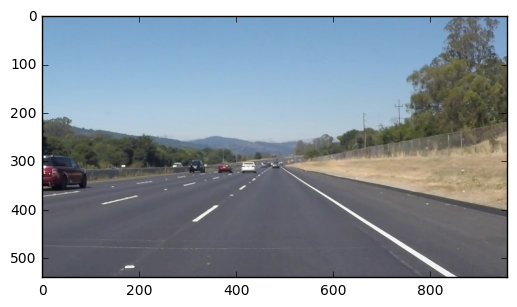

In [42]:
plt.imshow(image)

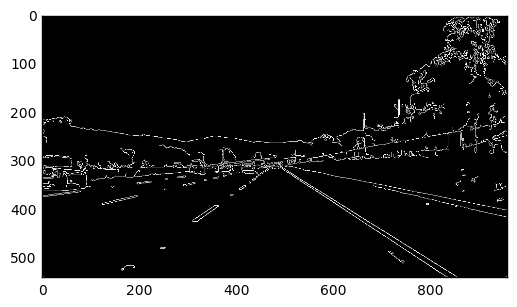

In [43]:
edges = cv2.Canny(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY),50,150)
plt.imshow(edges,cmap='Greys_r')

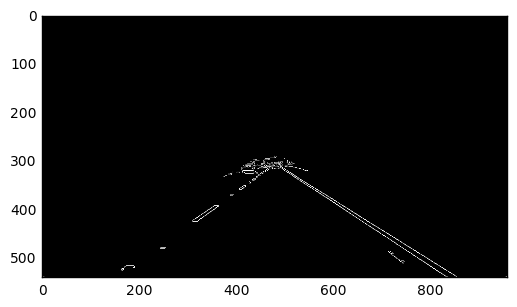

In [44]:
mask=np.zeros_like(edges)
ignore_mask_color=255
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450,290),(490,290),(imshape[1],imshape[0])]],dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(edges, mask)
#cv2.circle(masked_edges,(450,290),5,(0,255,0),10)
plt.imshow(masked_edges,cmap='Greys_r')

slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope: 0.624040920716  dist: 460.8871879321446
slope: 0.649390243902  dist: 391.09206077341946
slope: 0.636363636364  dist: 78.23042886243178
slope: 0.610169491525  dist: 69.1158447825099
slope: 0.765957446809  dist: 59.20304046246274
slope: 0.634615384615  dist: 61.587336360651285
slope: 0.642857142857  dist: 49.92995093127971
slope: 0.636363636364  dist: 78.23042886243178
slope: 0.625  dist: 56.60388679233962
slope: -0.775280898876  dist: 112.61438629233834
slope: -0.719626168224  dist: 131.8256424221024
slope: -0.682926829268  dist: 49.64876634922564
slope: -0.704545

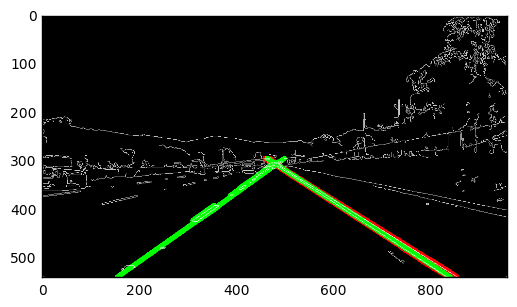

In [45]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 25    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
process_lines(lines)

#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [8]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image.shape

(540, 960, 3)

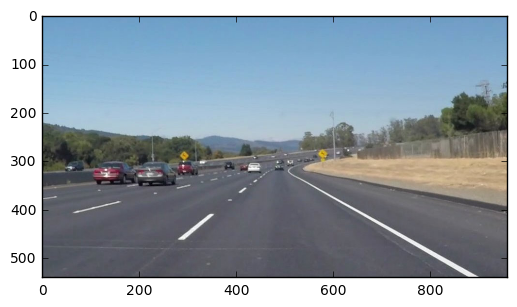

In [9]:
plt.imshow(image)

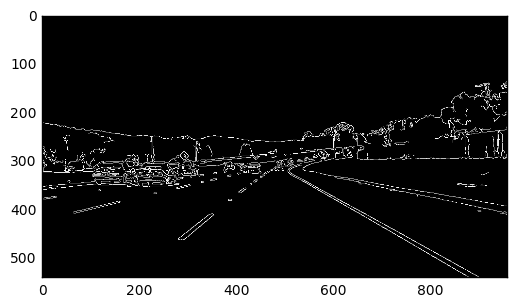

In [10]:
edges = cv2.Canny(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY),50,150)
plt.imshow(edges,cmap='Greys_r')

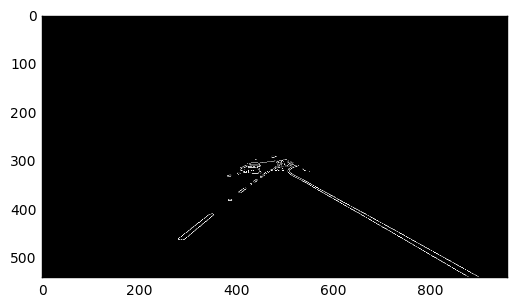

In [11]:
mask=np.zeros_like(edges)
ignore_mask_color=255
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450,290),(490,290),(imshape[1],imshape[0])]],dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(edges, mask)
cv2.circle(masked_edges,(450,290),5,(0,255,0),10)
plt.imshow(masked_edges,cmap='Greys_r')

points x1,x2,y1,y2: 470 898 302 539
slope: 0.553738317757
dist: 489.2371613031864
points x1,x2,y1,y2: 467 878 302 539
slope: 0.576642335766
dist: 474.43650787012587
points x1,x2,y1,y2: 383 493 381 299
slope: -0.745454545455
dist: 137.20058308913997
points x1,x2,y1,y2: 385 502 382 297
slope: -0.726495726496
dist: 144.61673485458036
points x1,x2,y1,y2: 383 436 382 341
slope: -0.77358490566
dist: 67.00746227100382
points x1,x2,y1,y2: 281 341 462 412
slope: -0.833333333333
dist: 78.10249675906654
points x1,x2,y1,y2: 382 447 332 317
slope: -0.230769230769
dist: 66.70832032063167
points x1,x2,y1,y2: 629 898 389 538
slope: 0.553903345725
dist: 307.5093494513622
points x1,x2,y1,y2: 382 448 330 316
slope: -0.212121212121
dist: 67.468511173732
points x1,x2,y1,y2: 409 449 317 312
slope: -0.125
dist: 40.311288741492746
points x1,x2,y1,y2: 295 353 461 412
slope: -0.844827586207
dist: 75.92759709091287
points x1,x2,y1,y2: 455 504 303 297
slope: -0.122448979592
dist: 49.36598018878993
points x1,x2,y1

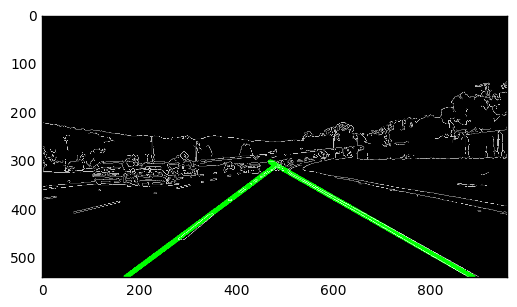

In [12]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 25    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
process_lines(lines)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [13]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image.shape

(540, 960, 3)

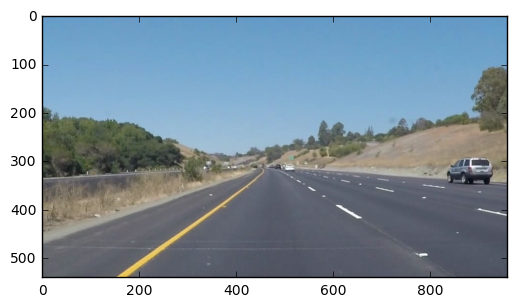

In [14]:
plt.imshow(image)

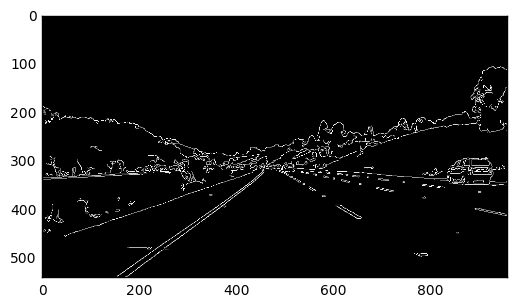

In [15]:
edges = cv2.Canny(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY),50,150)
plt.imshow(edges,cmap='Greys_r')

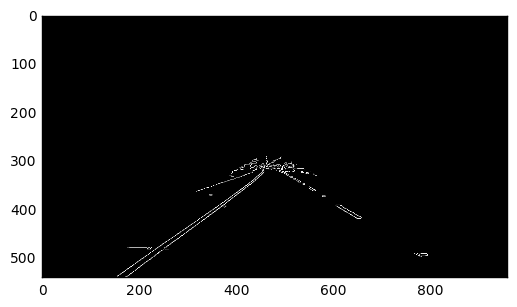

In [16]:
mask=np.zeros_like(edges)
ignore_mask_color=255
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450,290),(490,290),(imshape[1],imshape[0])]],dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(edges, mask)
cv2.circle(masked_edges,(450,290),5,(0,255,0),10)
plt.imshow(masked_edges,cmap='Greys_r')

points x1,x2,y1,y2: 154 483 538 308
slope: -0.699088145897
dist: 401.4237162899073
points x1,x2,y1,y2: 172 376 539 390
slope: -0.730392156863
dist: 252.62026838715852
points x1,x2,y1,y2: 320 417 362 330
slope: -0.329896907216
dist: 102.1420579389313
points x1,x2,y1,y2: 610 658 391 417
slope: 0.541666666667
dist: 54.589376255824725
points x1,x2,y1,y2: 421 547 307 324
slope: 0.134920634921
dist: 127.1416532848303
points x1,x2,y1,y2: 370 421 392 356
slope: -0.705882352941
dist: 62.42595614005443
points x1,x2,y1,y2: 462 579 295 374
slope: 0.675213675214
dist: 141.1736519326464
points x1,x2,y1,y2: 429 510 304 313
slope: 0.111111111111
dist: 81.49846624323675
points x1,x2,y1,y2: 412 539 313 316
slope: 0.0236220472441
dist: 127.03542812932147
points x1,x2,y1,y2: 423 477 348 310
slope: -0.703703703704
dist: 66.03029607687671
points x1,x2,y1,y2: 462 504 304 330
slope: 0.619047619048
dist: 49.39635614091387
points x1,x2,y1,y2: 605 653 393 419
slope: 0.541666666667
dist: 54.589376255824725
points

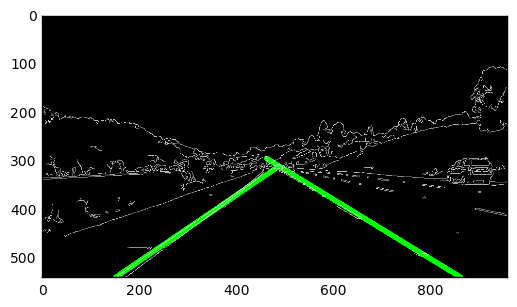

In [17]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 25    # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

process_lines(lines)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [18]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image.shape

(540, 960, 3)

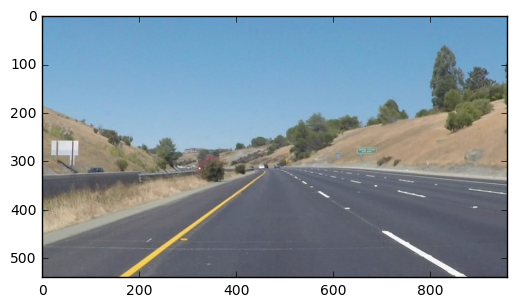

In [19]:
plt.imshow(image)

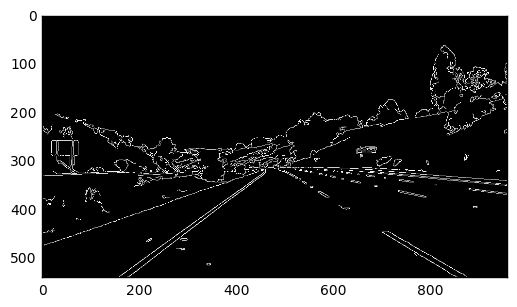

In [20]:
edges = cv2.Canny(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY),50,150)
plt.imshow(edges,cmap='Greys_r')

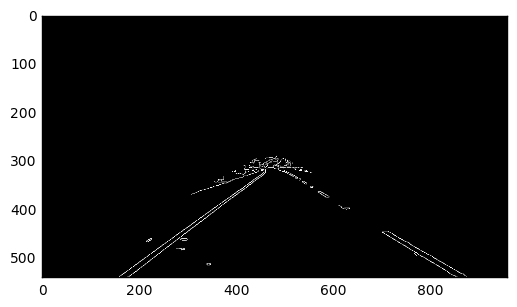

In [21]:
mask=np.zeros_like(edges)
ignore_mask_color=255
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450,290),(490,290),(imshape[1],imshape[0])]],dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(edges, mask)
cv2.circle(masked_edges,(450,290),5,(0,255,0),10)
plt.imshow(masked_edges,cmap='Greys_r')

slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
slope > 0.5 and m < 0.8
slope > 0.5 and m < 0.8
slope < -0.5 and m > -0.8
numRight slope: 0.624040920716  dist: 460.8871879321446
numRight slope: 0.649390243902  dist: 391.09206077341946
numRight slope: 0.636363636364  dist: 78.23042886243178
numRight slope: 0.610169491525  dist: 69.1158447825099
numRight slope: 0.765957446809  dist: 59.20304046246274
numRight slope: 0.634615384615  dist: 61.587336360651285
numRight slope: 0.642857142857  dist: 49.92995093127971
numRight slope: 0.636363636364  dist: 78.23042886243178
numRight slope: 0.625  dist: 56.60388679233962
numLeft slope: -0.775280898876  dist: 112.61438629233834
numLeft slope: -0.71962

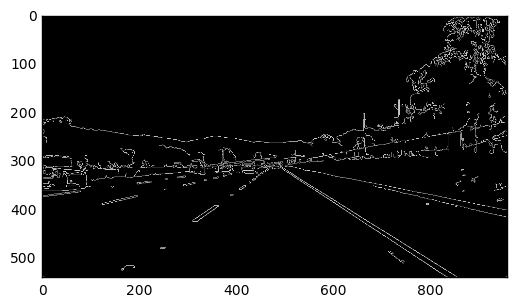

In [127]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 25    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

process_lines(lines)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [23]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image.shape

(540, 960, 3)

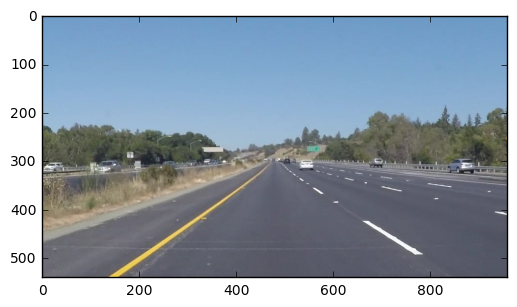

In [24]:
plt.imshow(image)

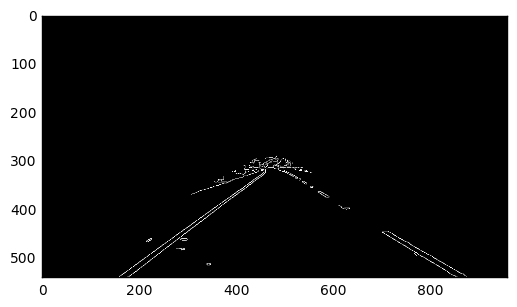

In [25]:
mask=np.zeros_like(edges)
ignore_mask_color=255
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450,290),(490,290),(imshape[1],imshape[0])]],dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(edges, mask)
cv2.circle(masked_edges,(450,290),5,(0,255,0),10)
plt.imshow(masked_edges,cmap='Greys_r')

points x1,x2,y1,y2: 159 404 539 361
slope: -0.726530612245
dist: 302.8349385391322
points x1,x2,y1,y2: 238 492 492 300
slope: -0.755905511811
dist: 318.4022612985027
points x1,x2,y1,y2: 463 590 302 375
slope: 0.574803149606
dist: 146.48549416239138
points x1,x2,y1,y2: 708 869 445 534
slope: 0.552795031056
dist: 183.96195258802837
points x1,x2,y1,y2: 700 855 446 539
slope: 0.6
dist: 180.75950874020432
points x1,x2,y1,y2: 176 221 539 507
slope: -0.711111111111
dist: 55.21775076911409
points x1,x2,y1,y2: 415 516 331 304
slope: -0.267326732673
dist: 104.546640309481
points x1,x2,y1,y2: 384 468 377 314
slope: -0.75
dist: 105.0
points x1,x2,y1,y2: 333 375 360 342
slope: -0.428571428571
dist: 45.69463863518345
points x1,x2,y1,y2: 712 757 445 470
slope: 0.555555555556
dist: 51.478150704935004
points x1,x2,y1,y2: 460 591 295 373
slope: 0.595419847328
dist: 152.46311029229332
points x1,x2,y1,y2: 417 534 316 314
slope: -0.017094017094
dist: 117.01709276853532
points x1,x2,y1,y2: 398 446 319 319
s

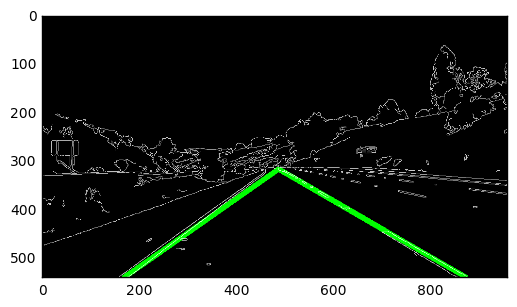

In [27]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 25    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

process_lines(lines)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [28]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image.shape

(540, 960, 3)

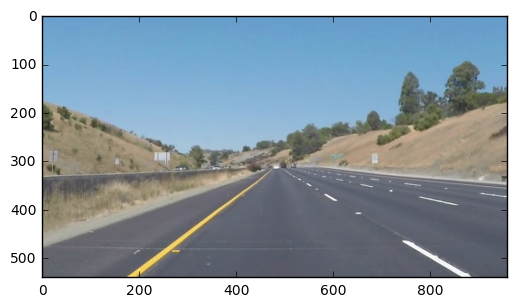

In [29]:
plt.imshow(image)

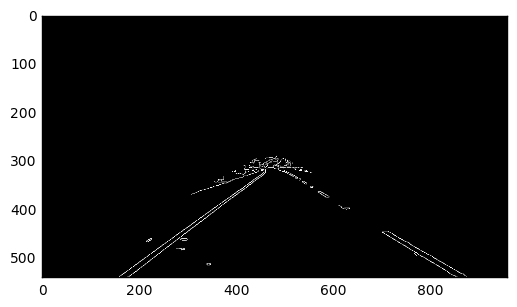

In [30]:
mask=np.zeros_like(edges)
ignore_mask_color=255
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450,290),(490,290),(imshape[1],imshape[0])]],dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(edges, mask)
cv2.circle(masked_edges,(450,290),5,(0,255,0),10)
plt.imshow(masked_edges,cmap='Greys_r')

points x1,x2,y1,y2: 159 404 539 361
slope: -0.726530612245
dist: 302.8349385391322
points x1,x2,y1,y2: 238 492 492 300
slope: -0.755905511811
dist: 318.4022612985027
points x1,x2,y1,y2: 463 590 302 375
slope: 0.574803149606
dist: 146.48549416239138
points x1,x2,y1,y2: 708 869 445 534
slope: 0.552795031056
dist: 183.96195258802837
points x1,x2,y1,y2: 700 855 446 539
slope: 0.6
dist: 180.75950874020432
points x1,x2,y1,y2: 176 221 539 507
slope: -0.711111111111
dist: 55.21775076911409
points x1,x2,y1,y2: 415 516 331 304
slope: -0.267326732673
dist: 104.546640309481
points x1,x2,y1,y2: 384 468 377 314
slope: -0.75
dist: 105.0
points x1,x2,y1,y2: 333 375 360 342
slope: -0.428571428571
dist: 45.69463863518345
points x1,x2,y1,y2: 712 757 445 470
slope: 0.555555555556
dist: 51.478150704935004
points x1,x2,y1,y2: 460 591 295 373
slope: 0.595419847328
dist: 152.46311029229332
points x1,x2,y1,y2: 417 534 316 314
slope: -0.017094017094
dist: 117.01709276853532
points x1,x2,y1,y2: 398 446 319 319
s

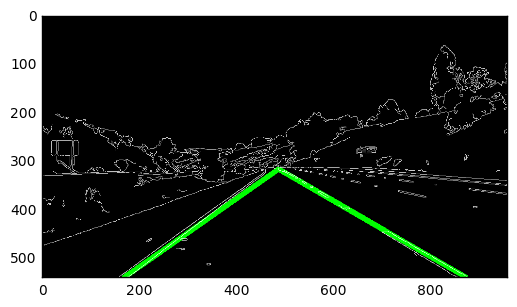

In [31]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 25    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

process_lines(lines)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [122]:
#video stuff
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    print ("ysize:",ysize," xsize:",xsize)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    gauss = gaussian_blur(gray,9)
    edges = cv2.Canny(gauss,50,150)
    mask=np.zeros_like(edges)
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #ignore_mask_color = 255
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450,290),(490,290),(imshape[1],imshape[0])]],dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_edges = cv2.bitwise_and(edges, mask)
    #cv2.circle(masked_edges,(450,290),5,(0,255,0),10)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 25    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    #process_lines(lines)

    numRight=[]
    numLeft=[]
    for line in lines:
         for x1,y1,x2,y2 in line:
                m = slope(x1,x2,y1,y2)
                d = dist(x1,x2,y1,y2)
                print ("points x1,x2,y1,y2:", x1,x2,y1,y2)
                print ("slope:",m,"dist:", d)
                if m > 0.5 and m < 0.8:
                    numRight.append(((x1,x2,y1,y2),m,d))
                    #print ("slope > 0.5 and m < 0.8")
                    #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),2)
                elif m < -0.5 and m > -0.8 :
                    numLeft.append(((x1,x2,y1,y2),m,d))
                    #print ("slope < -0.5 and m > -0.8")
                    #cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),2)
    
    for r in numRight:
        print ("numRight slope:",r[1]," dist:", r[2])
    for l in numLeft:
        print("numLeft slope:",l[1], " dist:",l[2])
    
    avgSlopeRight = avgSlope(numRight)
    print ("avgSlopeRight:",avgSlopeRight)
    avgSlopeLeft = avgSlope(numLeft)
    print ("avgSlopeLeft:",avgSlopeLeft)
    
    tupleRight = longestLine(numRight)
    print ("x,y points longest line tupleRight",tupleRight)
    tupleLeft = longestLine(numLeft)
    print ("x,y points longest line tupleLeft",tupleLeft)

    #draw the interpolated lines in line_image
    xleft = math.floor((ysize-(tupleLeft[0][2]-avgSlopeLeft*tupleLeft[0][0]))/avgSlopeLeft)
    print ("xleft:",xleft)
    #print("tupleleft[0][0]", tupleLeft[0][0])
    #print("tupleLeft[0][2]", tupleLeft[0][2])
    print ("drawing left line from:",xleft,ysize," to:",tupleLeft[0][0],tupleLeft[0][2])
    cv2.line(line_image,(xleft,ysize),(tupleLeft[0][0],tupleLeft[0][2]),(255,0,0),2)
    
    xright = math.floor((ysize-(tupleRight[0][2]-avgSlopeRight*tupleRight[0][0]))/avgSlopeRight)
    print ("drawing right line from:",xright,ysize," to:",tupleRight[0][0],tupleRight[0][2])
    #print("tupleleft[0][0]", tupleRight[0][0])
    #print("tupleLeft[0][2]", tupleRight[0][2])
    cv2.line(line_image,(xright,ysize),(tupleRight[0][0],tupleRight[0][2]),(255,0,0),2)
    
    b_left = tupleLeft[0][2] - avgSlopeLeft * tupleLeft[0][0]
    b_right = tupleRight[0][2] -avgSlopeRight * tupleRight[0][0]
    
    x_vp = (b_right - b_left)/(avgSlopeLeft - avgSlopeRight)
    y_vp = avgSlopeRight * ((b_right-b_left)/(avgSlopeLeft-avgSlopeRight)) + b_right
    
    print ("x_vp:", x_vp, " y_vp:",y_vp)
    
    #floor them so they are legit pixel coordinates
    x_vp = math.floor(x_vp)
    y_vp = math.floor(y_vp)
    
    #print ('70%',(.7*y_vp))
    
    #find left/right lines for .7 of vanishing point
    
    
    #draw the line from tuple to vp or some percentage of vp. 
    cv2.line(line_image,(tupleLeft[0][0],tupleLeft[0][2]),(x_vp,y_vp),(255,0,0),2)
    
    cv2.line(line_image,(tupleRight[0][0],tupleRight[0][2]),(x_vp,y_vp),(255,0,0),2)
    
    
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    w_image = weighted_img(lines_edges, image)
    return w_image




In [123]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

ysize: 540  xsize: 960
points x1,x2,y1,y2: 756 867 471 536
slope: 0.585585585586 dist: 128.63125592172378
points x1,x2,y1,y2: 187 300 513 431
slope: -0.725663716814 dist: 139.61733416735902
points x1,x2,y1,y2: 458 720 293 457
slope: 0.625954198473 dist: 309.0954545120326
points x1,x2,y1,y2: 577 676 361 422
slope: 0.616161616162 dist: 116.2841347734075
points x1,x2,y1,y2: 503 561 316 353
slope: 0.637931034483 dist: 68.79680225126747
points x1,x2,y1,y2: 713 847 454 538
slope: 0.626865671642 dist: 158.15182578775372
points x1,x2,y1,y2: 388 429 369 337
slope: -0.780487804878 dist: 52.009614495783374
points x1,x2,y1,y2: 203 310 514 433
slope: -0.757009345794 dist: 134.2013412749664
points x1,x2,y1,y2: 363 433 391 340
slope: -0.728571428571 dist: 86.6083136886985
points x1,x2,y1,y2: 358 402 391 357
slope: -0.772727272727 dist: 55.60575509783138
points x1,x2,y1,y2: 714 760 444 473
slope: 0.630434782609 dist: 54.378304497290095
points x1,x2,y1,y2: 460 685 293 434
slope: 0.626666666667 dist: 26


  0%|          | 0/222 [00:00<?, ?it/s]

ysize: 540  xsize: 960
points x1,x2,y1,y2: 756 867 471 536
slope: 0.585585585586 dist: 128.63125592172378
points x1,x2,y1,y2: 187 300 513 431
slope: -0.725663716814 dist: 139.61733416735902
points x1,x2,y1,y2: 458 720 293 457
slope: 0.625954198473 dist: 309.0954545120326
points x1,x2,y1,y2: 577 676 361 422
slope: 0.616161616162 dist: 116.2841347734075
points x1,x2,y1,y2: 503 561 316 353
slope: 0.637931034483 dist: 68.79680225126747
points x1,x2,y1,y2: 713 847 454 538
slope: 0.626865671642 dist: 158.15182578775372
points x1,x2,y1,y2: 388 429 369 337
slope: -0.780487804878 dist: 52.009614495783374
points x1,x2,y1,y2: 203 310 514 433
slope: -0.757009345794 dist: 134.2013412749664
points x1,x2,y1,y2: 363 433 391 340
slope: -0.728571428571 dist: 86.6083136886985
points x1,x2,y1,y2: 358 402 391 357
slope: -0.772727272727 dist: 55.60575509783138
points x1,x2,y1,y2: 714 760 444 473
slope: 0.630434782609 dist: 54.378304497290095
points x1,x2,y1,y2: 460 685 293 434
slope: 0.626666666667 dist: 26

ZeroDivisionError: division by zero